# **Task 1: Medical Image Classification with PathMNIST Dataset**

In [3]:
# Install necessary libraries
!pip install torch torchvision medmnist matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=4d0c4c2c1bdc34b968ba8a9105f511296bf1a13225f667559b1d2574fcfa2a5c
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


**Step 1: Data Loading**

In [12]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PathMNIST

# Ensure the root directory exists
root_dir = './data'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
# Set download=True if not already downloaded
train_set = PathMNIST(root=root_dir, split='train', transform=transform, download=True)
val_set = PathMNIST(root=root_dir, split='val', transform=transform, download=True)
test_set = PathMNIST(root=root_dir, split='test', transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Dataset loaded successfully!")


Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Dataset loaded successfully!


**Step 2: Visualize Sample Data**

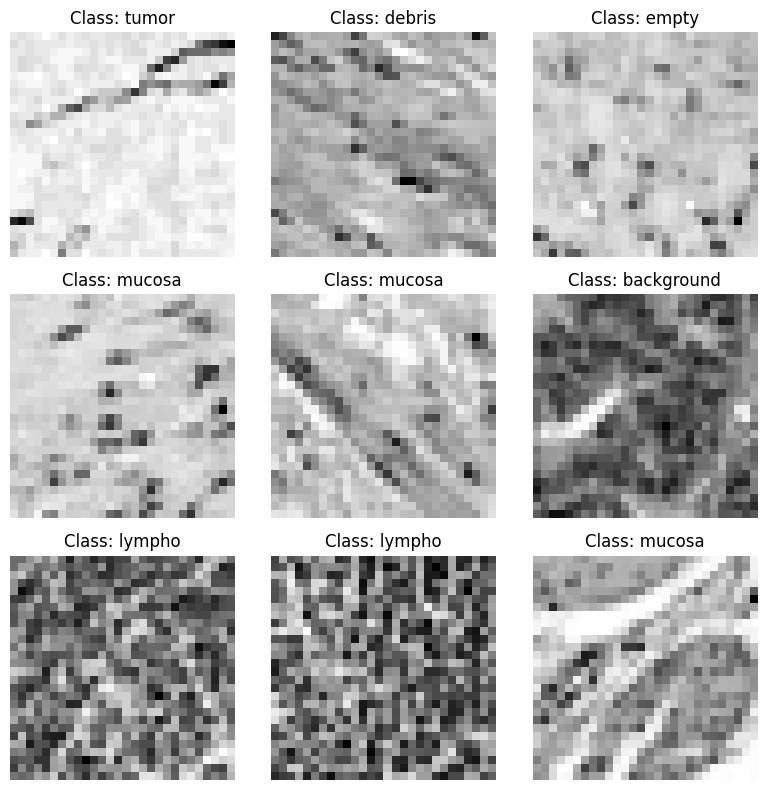

In [13]:
import matplotlib.pyplot as plt

# Class names corresponding to each label
class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa",
               "adipose", "empty", "background"]

# Display 3x3 grid of images with class names
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    img, label = train_set[i]
    img = img[0]  # Take only the first channel to make it (28, 28)
    class_name = class_names[label.item()]  # Convert label to integer
    axs[i // 3, i % 3].imshow(img, cmap='gray')
    axs[i // 3, i % 3].set_title(f"Class: {class_name}")
    axs[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


**Step 3: Define the CNN Model**

In [17]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Change input channels to 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


**Step 4: Train the Model**

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the model, criterion, and optimizer
model = CNNModel()  # Instantiate the model
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have train_loader and val_loader defined already
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.squeeze(1)  # Ensure labels are 1D
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation accuracy after each epoch
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.squeeze(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print epoch loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Save model at the end of each epoch (optional)
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

# Save final model after all epochs
torch.save(model.state_dict(), "bscs22115_final_model.pth")


Epoch [1/10], Loss: 0.7860, Accuracy: 78.10%
Epoch [2/10], Loss: 0.4926, Accuracy: 85.32%
Epoch [3/10], Loss: 0.3821, Accuracy: 87.37%
Epoch [4/10], Loss: 0.3115, Accuracy: 87.02%
Epoch [5/10], Loss: 0.2598, Accuracy: 89.30%
Epoch [6/10], Loss: 0.2172, Accuracy: 90.59%
Epoch [7/10], Loss: 0.1843, Accuracy: 91.39%
Epoch [8/10], Loss: 0.1566, Accuracy: 92.22%
Epoch [9/10], Loss: 0.1368, Accuracy: 91.04%
Epoch [10/10], Loss: 0.1170, Accuracy: 91.78%


**Step 5: Evaluate the Model**

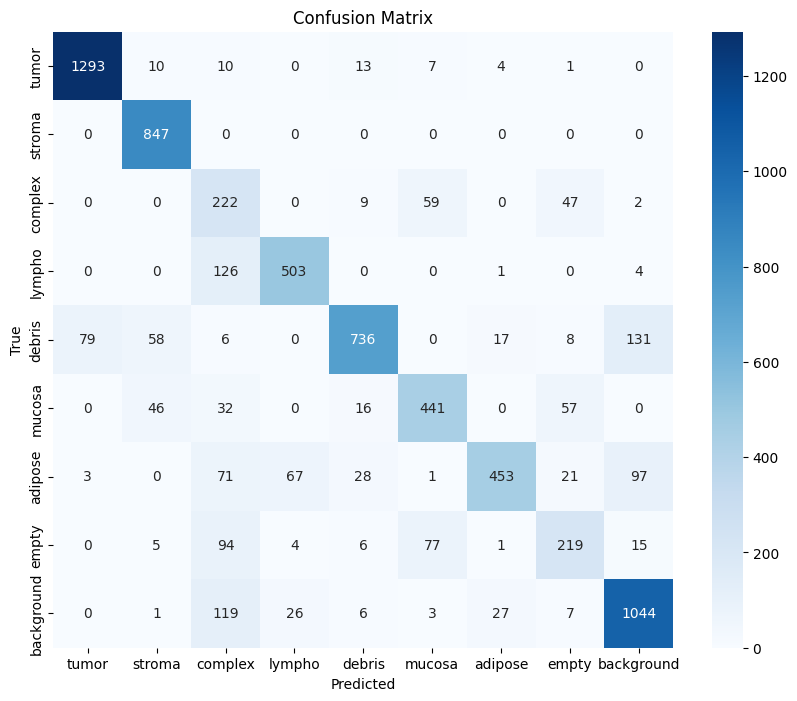

              precision    recall  f1-score   support

       tumor       0.94      0.97      0.95      1338
      stroma       0.88      1.00      0.93       847
     complex       0.33      0.65      0.44       339
      lympho       0.84      0.79      0.82       634
      debris       0.90      0.71      0.80      1035
      mucosa       0.75      0.74      0.75       592
     adipose       0.90      0.61      0.73       741
       empty       0.61      0.52      0.56       421
  background       0.81      0.85      0.83      1233

    accuracy                           0.80      7180
   macro avg       0.77      0.76      0.76      7180
weighted avg       0.83      0.80      0.81      7180



In [20]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for PathMNIST
class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa",
               "adipose", "empty", "background"]  # Replace with actual class names if available

# Ensure model is on the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to device

# Test model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.squeeze().tolist())  # Squeeze if labels have an extra dimension
        y_pred.extend(predicted.tolist())

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


# **Task 2: Image Segmentation with UNet using Pascal VOC 2012**

In [ ]:
# Install necessary libraries
!pip install torch torchvision matplotlib


# **Data Loading**

In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformations (for RGB images)
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images with ImageNet mean and std
])

# Mask transformations (for segmentation masks, no normalization)
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the mask to 128x128
    transforms.ToTensor()  # Convert mask to tensor
])

# Load the VOCSegmentation dataset (train and validation splits)
train_data = datasets.VOCSegmentation(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=image_transform,  # Apply image_transform to images
    target_transform=mask_transform  # Apply mask_transform to segmentation masks
)

val_data = datasets.VOCSegmentation(
    root='./data',
    year='2012',
    image_set='val',
    download=True,
    transform=image_transform,  # Apply image_transform to images
    target_transform=mask_transform  # Apply mask_transform to segmentation masks
)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

# Check if data is loaded properly by printing a batch
data_iter = iter(train_loader)
images, masks = next(data_iter)
print(f"Image batch shape: {images.shape}")
print(f"Mask batch shape: {masks.shape}")


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Image batch shape: torch.Size([16, 3, 128, 128])
Mask batch shape: torch.Size([16, 1, 128, 128])


# **Visualizing stage**

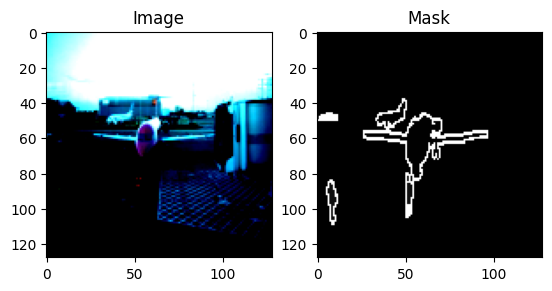

In [24]:
# Display a sample image and its mask
image, mask = train_data[0]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image.permute(1, 2, 0))
ax1.set_title("Image")
ax2.imshow(mask.squeeze(), cmap="gray")
ax2.set_title("Mask")
plt.show()


# **Implement a Simple UNet Model**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset  # or use another dataset

# Define the UNet model class
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):  # RGB images, Binary segmentation (2 classes)
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc_conv1 = self.double_conv(in_channels, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder (upsampling)
        self.upconv4 = self.upconv(1024, 512)
        self.dec_conv4 = self.double_conv(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec_conv3 = self.double_conv(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec_conv2 = self.double_conv(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec_conv1 = self.double_conv(128, 64)

        # Final output layer (binary segmentation)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(nn.functional.max_pool2d(enc1, 2))
        enc3 = self.enc_conv3(nn.functional.max_pool2d(enc2, 2))
        enc4 = self.enc_conv4(nn.functional.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(nn.functional.max_pool2d(enc4, 2))

        # Decoder path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec_conv4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)

        # Final layer
        out = self.final_conv(dec1)
        return out


# **Train the model**

In [30]:

# Create random tensors for images and masks (replace with real data)
num_classes = 2  # Binary segmentation (e.g., background and foreground)
images = torch.randn(100, 3, 128, 128)  # 100 random RGB images (128x128)
masks = torch.randint(0, num_classes, (100, 128, 128))  # 100 random masks (0 or 1 for binary segmentation)

# Create dataset and DataLoader
dataset = TensorDataset(images, masks)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize the model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=num_classes)  # 3 channels for RGB, 2 for binary segmentation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function (Cross-Entropy Loss for segmentation tasks)
criterion = nn.CrossEntropyLoss()

# Set up the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        # Move images and masks to the appropriate device (CPU or GPU)
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Get model predictions
        outputs = model(images)  # Model outputs should be of shape (batch_size, num_classes, H, W)

        # Compute the loss
        loss = criterion(outputs, masks)  # CrossEntropyLoss expects class indices, not one-hot encoded

        # Backward pass: Compute gradients
        loss.backward()

        # Optimize the model parameters
        optimizer.step()

        # Accumulate loss for reporting
        train_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'bscs22115_unet_model.pth')
print("Model saved to 'unet_model.pth'")


Epoch [1/10], Loss: 0.6933
Epoch [2/10], Loss: 0.6931
Epoch [3/10], Loss: 0.6931
Epoch [4/10], Loss: 0.6931
Epoch [5/10], Loss: 0.6931
Epoch [6/10], Loss: 0.6931
Epoch [7/10], Loss: 0.6930
Epoch [8/10], Loss: 0.6929
Epoch [9/10], Loss: 0.6927
Epoch [10/10], Loss: 0.6926
Model saved to 'unet_model.pth'


# **Visualization**

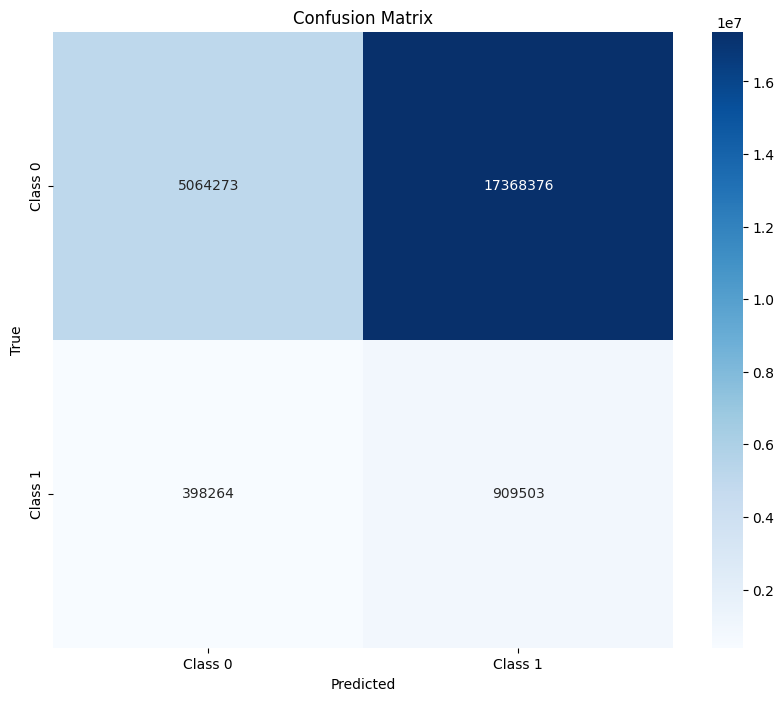

              precision    recall  f1-score   support

     Class 0       0.93      0.23      0.36  22432649
     Class 1       0.05      0.70      0.09   1307767

    accuracy                           0.25  23740416
   macro avg       0.49      0.46      0.23  23740416
weighted avg       0.88      0.25      0.35  23740416



In [35]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of classes for segmentation (replace with your actual value)
num_classes = 2  # For binary segmentation (e.g., background, foreground)

# Define class names (adjust based on your dataset)
class_names = [f"Class {i}" for i in range(num_classes)]  # Replace with actual class names if available

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Test model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, masks in val_loader:  # Use your validation or test DataLoader
        images = images.to(device)  # Move images to the same device as the model
        masks = masks.to(device).long()  # Ensure masks are in integer format (long type for classification)

        outputs = model(images)  # Model outputs (N, num_classes, H, W)

        # Apply softmax (if the model outputs raw logits) and then get the predicted class
        predicted = torch.argmax(outputs, dim=1)  # Predicted mask (N, H, W)

        # Flatten the output and ground truth to 1D arrays for comparison
        y_true.extend(masks.flatten().cpu().numpy())  # Ensure masks are in integer format
        y_pred.extend(predicted.flatten().cpu().numpy())  # Ensure predictions are in integer format

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))
